# Lesson of the day: Getting familiar with HDF5 format for images and other data types
The goal is to import a set of images, convert them to numpy arrays, pass them through some neural network (such as VGG19) and write the input and output in the form of training records to the hdf file and then view it using HDF5 Viewer.

In [1]:
import numpy as np
import h5py
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
import keras
from keras.preprocessing.image import img_to_array
from keras.applications.imagenet_utils import decode_predictions
from skimage import io

# Stuff specific to the notbook running on jupyter
from IPython.display import clear_output
%matplotlib inline

Using TensorFlow backend.


We need to wrap up our stuff into some neat functions, so let's define our "API"

In [2]:
# DEFINE OUR ENTIRE INTERFACE

# Function for loading a single image, returning it in RGB formatted numpy array of float32
def load_image(impath, resize_to=(224,224)):
    im = cv2.imread(impath)
    im = cv2.resize(im, resize_to)
    im = np.array(cv2.cvtColor(im, cv2.COLOR_BGR2RGB)).astype(np.float32)
    return im

# Goes through image paths specified in ds_fpaths, passes them through the model
# and returns both, images and predictions as numpy arrays of float32s
def process_dataset(model, ds_fpaths):
    images = []
    for fpath in ds_fpaths:
        images.append( load_image(fpath) )
    images = np.array(images)
    preds = np.array(model.predict(images)).astype(np.float32)
    
    return images, preds

# Prints the prediction records with names using imagenet's API from keras
def print_prediction(pred):
    ids_and_labels = decode_predictions(np.expand_dims(pred,0))[0]
    for record in ids_and_labels:
        print('Class: {}, p: {}'.format(record[1], record[2]))

# Displays images and printed predictions for the entire set from numpy arrays: images and preds
def display_images_and_preds(images, preds):
    for i in range(0, images.shape[0]):
        plt.imshow(images[i,].astype(np.uint8))
        plt.show()
        print_prediction(preds[i,])        

# Saves it all in the HDS5 file specified by df5_fpath
def store_images_and_preds(hdf5_fpath, images, preds):
    with h5py.File(hdf5_fpath, 'w') as h5:
        grp = h5.create_group('datum')
        grp.create_dataset('images', shape=images.shape, data=images)
        grp.create_dataset('preds', shape=preds.shape, data=preds)
        
# Uses the model to process all the images from ds_fpaths and saves it all into hdf5_fpath
def process_and_store_all(model, hdf5_fpath, ds_fpaths):
    images, preds = process_dataset(model, ds_fpaths)
    store_images_and_preds(hdf5_fpath, images, preds)
    return images, preds

def load_stored_images_and_preds(hdf5_fpath):
    with h5py.File(hdf5_fpath, 'r') as h5:
        group = h5.get('datum')
        images = np.array(group['images'])
        preds = np.array(group['preds'])
        return images, preds

Now we need to load our model, for simplicity let's use VGG19 which is nicely included in keras's libraries. We only want to do it once as this is somewhat time-consuming operation...

In [3]:
model = keras.applications.vgg19.VGG19(include_top=True, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=1000)

Now we need some images and desired output database file name. Using our API we will create class predictions for images, store it all and display the output :)

Images stored in the daset file ds.h5


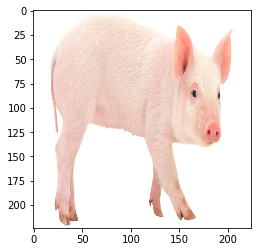

Class: hog, p: 0.6156774759292603
Class: piggy_bank, p: 0.32352250814437866
Class: wild_boar, p: 0.05301125720143318
Class: armadillo, p: 0.001755504054017365
Class: warthog, p: 0.0009753647027537227


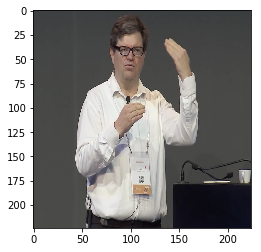

Class: lab_coat, p: 0.9512001276016235
Class: gasmask, p: 0.005840050056576729
Class: Windsor_tie, p: 0.004365768749266863
Class: pajama, p: 0.003903739620000124
Class: bow_tie, p: 0.003889755578711629


In [4]:
# 
ds_fpaths = ['sample_images/piggy.jpg', 'sample_images/yann.jpg']
hdf5_fpath = 'ds.h5'

images, preds = process_and_store_all(model, hdf5_fpath, ds_fpaths)
print('Images stored in the daset file {}'.format(hdf5_fpath))
display_images_and_preds(images, preds)

Now let's verify that what we can load is indeed what we saved. We are going to use the visual inspection method. Presented data should look JUST like the above.

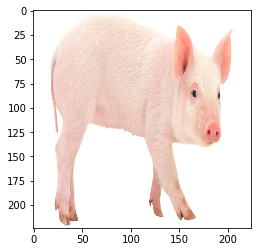

Class: hog, p: 0.6156774759292603
Class: piggy_bank, p: 0.32352250814437866
Class: wild_boar, p: 0.05301125720143318
Class: armadillo, p: 0.001755504054017365
Class: warthog, p: 0.0009753647027537227


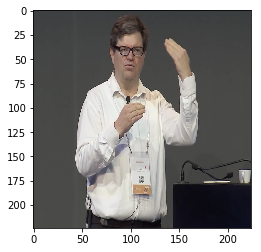

Class: lab_coat, p: 0.9512001276016235
Class: gasmask, p: 0.005840050056576729
Class: Windsor_tie, p: 0.004365768749266863
Class: pajama, p: 0.003903739620000124
Class: bow_tie, p: 0.003889755578711629


In [5]:
images_rev, preds_rev = load_stored_images_and_preds(hdf5_fpath)
display_images_and_preds(images, preds)